### Check ratio of signal to noise in data

In [3]:
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from pycbc import transforms
sys.path.insert(0, "../data")
from pycbc_draw_samples import read_config

import matplotlib.pyplot as plt

In [5]:
ini_parent = '../ini_files'
dataset = 4 # MinimalOTF made specifically for dataset 4
CONFIG_PATH = "{}/ds{}.ini".format(ini_parent, dataset)
randomsampler, waveform_transforms = read_config(path=CONFIG_PATH)

In [6]:
def get_waveform_parameters(seed, num_samples):
    # Draw sample using config
    np.random.seed(seed)
    # Draw samples from prior distribution.
    prior = randomsampler.rvs(size=num_samples)
    # Apply parameter transformation.
    prior = transforms.apply_transforms(prior, waveform_transforms)
    return prior

In [7]:
priors = get_waveform_parameters(seed=42, num_samples=1_500_000)
fields = {fname: n for n, fname in enumerate(list(priors.fieldnames))}
fields

{'mass1': 0,
 'mass2': 1,
 'ra': 2,
 'dec': 3,
 'inclination': 4,
 'coa_phase': 5,
 'polarization': 6,
 'chirp_distance': 7,
 'spin1_a': 8,
 'spin1_azimuthal': 9,
 'spin1_polar': 10,
 'spin2_a': 11,
 'spin2_azimuthal': 12,
 'spin2_polar': 13,
 'injection_time': 14,
 'tc': 15,
 'spin1x': 16,
 'spin1y': 17,
 'spin1z': 18,
 'spin2x': 19,
 'spin2y': 20,
 'spin2z': 21,
 'mchirp': 22,
 'q': 23,
 'distance': 24}

In [ ]:
lf = 20.0 # Signal low freq cutoff
G = 6.67e-11
c = 3.0e8
tau = 5. * (8.*np.pi*lf)**(-8./3.) * (priors['mchirp']*1.989e30*G/c**3.)**(-5./3.)

In [ ]:
plt.figure(figsize=(9.0, 9.0))
plt.hist(tau, bins=100)
plt.xlabel("Signal Duration (s)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
# Sum all signal duration together and compare with the total duration of samples
# We have 2e6 samples per epoch out of which 1e6 are signals following the above distribution
sample_length_in_s = 15.0
num_samples_in_epoch = 3e6
total_waveform_duration = np.sum(tau)
total_duration = sample_length_in_s * num_samples_in_epoch
waveform_to_noise_duration_ratio = total_waveform_duration / total_duration
# factor by which to up weight signals
upweight_factor = (total_duration - total_waveform_duration) / total_waveform_duration

In [ ]:
print('total waveform duration = {} seconds'.format(total_waveform_duration))
print('total duration = {} seconds'.format(total_duration))
print('waveform to noise duration ratio = {}'.format(waveform_to_noise_duration_ratio))

In [ ]:
print(len(tau[tau>2.0])/1.5e6)
print(len(tau[tau>4.0])/1.5e6)
print(0.25*1.5e6, 0.05*1.5e6)

### Placing bounds on mass priors when using uniform mchirp prior

In [2]:
# Packages
from pycbc.conversions import _mass2_from_mchirp_mass1
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta

In [3]:
# Masses
ml = 7.0
mu = 50.0
mass1 = np.random.uniform(ml, mu, 100_000)
# mchirp bounds and uniform mchirp
mc_upper = (mu*mu / (mu + mu)**2.)**(3./5) * (mu + mu)
mc_lower = (ml*ml / (ml + ml)**2.)**(3./5) * (ml + ml)
mchirp = np.random.uniform(mc_lower, mc_upper, 100_000)

In [4]:
# Trying to place bounds on mass2
mass2 = [_mass2_from_mchirp_mass1(mc, m1) for mc, m1 in zip(mchirp, mass1)]

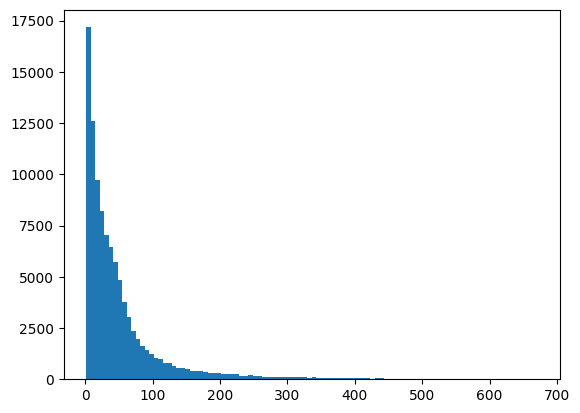

In [5]:
# Check mass2
plt.figure()
plt.hist(mass2, bins=100)
plt.show()

### Check prior modifications module

In [8]:
def get_uniform_masses(mass_lower, mass_upper, num_samples):
    # Get uniform mass distribution
    x_mass = [np.random.uniform(mass_lower, mass_upper, num_samples) for _ in range(2)]
    # Apply the mass constraint (mass2 <= mass1)
    masses = np.column_stack((x_mass[0], x_mass[1]))
    masses = np.fliplr(np.sort(masses, axis=1))
    # Sanity check
    assert all(masses[:,0] > masses[:,1]), "Mass1 > Mass2 in mass priors!"
    # Assign mass1 and mass2
    mass1 = masses[:,0]
    mass2 = masses[:,1]
    return (mass1, mass2)

In [9]:
def q_from_uniform_mass1_mass2(mass1, mass2):
    # Calculate mass ratio (mass1/mass2) on bounds [1, +inf]
    return mass1/mass2

In [10]:
def get_uniform_mchirp(ml, mu, num_samples, min_mchirp=None, max_mchirp=None, override=False):
    # m2 will always be slightly lower than m1, but (m, m) will give limit
    # that the mchirp will never reach but tends to as num_samples tends to inf.
    # Range for mchirp can be written as --> (min_mchirp, max_mchirp)
    if override:
        min_mchirp = min_mchirp
        max_mchirp = max_mchirp
    else:
        min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
        max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
    # Get uniform chirp mass
    uniform_mchirp = np.random.uniform(min_mchirp, max_mchirp, num_samples)
    return uniform_mchirp

In [11]:
def mass1_from_mchirp_q(mchirp, q):
    """Returns the primary mass from the given chirp mass and mass ratio."""
    mass1 = q**(2./5.) * (1.0 + q)**(1./5.) * mchirp
    return mass1

def mass2_from_mchirp_q(mchirp, q):
    """Returns the secondary mass from the given chirp mass and mass ratio."""
    mass2 = q**(-3./5.) * (1.0 + q)**(1./5.) * mchirp
    return mass2

def mass1_mass2_from_mchirp_q(mchirp, q):
    # Get mass1 and mass2 from mchirp and q
    mass1 = mass1_from_mchirp_q(mchirp, q)
    mass2 = mass2_from_mchirp_q(mchirp, q)
    return (mass1, mass2)

In [10]:
_m1, _m2 = get_uniform_masses(7., 50., 100_000)
q = q_from_uniform_mass1_mass2(_m1, _m2)
mchirp = get_uniform_mchirp(ml, mu, 100_000)
m1, m2 = mass1_mass2_from_mchirp_q(mchirp, q)
mchirp_check = (_m1*_m2/ (_m1+_m2)**2.)**(3./5) * (_m1 + _m2)

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax[0][0].hist(q, bins=40)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp, bins=40)
ax[0][1].hist(mchirp_check, bins=40,histtype="step")
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(m1, bins=40)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(m2, bins=40)
ax[1][1].set_xlabel('m2')
plt.show()

In [37]:
m1, m2 = get_uniform_masses(7., 50., 1_000_000_000)
q = m1/m2
mchirp = (m1*m2/ (m1+m2)**2.)**(3./5) * (m1 + m2)
idxs = np.where(mchirp > 0.0)

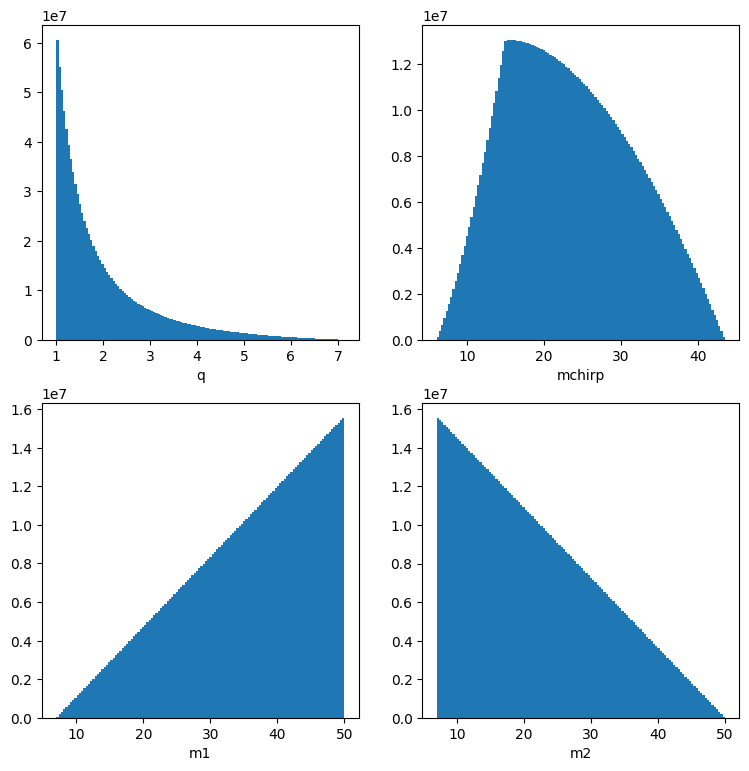

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax[0][0].hist(q, bins=128)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp[idxs], bins=128)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(m1[idxs], bins=128)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(m2[idxs], bins=128)
ax[1][1].set_xlabel('m2')
plt.show()

In [39]:
print(len(q[q>2])/len(q))
idx = np.argwhere(q > 2).flatten()
M = m1 + m2
print(len(M[idx][M[idx]>80]))

0.350445618
0


### Using CDFsnake to sample m1, m2 from uniform mchirp dependant on q

In [ ]:
# CDFsnake (courtesy of Christian Chapman-Bird)
# Refer https://github.com/CChapmanbird/CDF_snake/blob/main/examples/demo.ipynb
import sys
sys.path.insert(0, "./CDF_snake")
from CDF_snake import CDFSnake

In [ ]:
def pdf(q, mchirp):
    mr = q.copy()
    mass1 = mass1_from_mchirp_q(mchirp, mr)
    mass2 = mass2_from_mchirp_q(mchirp, mr)
    mr[mass1 > mu] = 0.0
    mr[mass1 < ml] = 0.0
    mr[mass2 > mu] = 0.0
    mr[mass2 < ml] = 0.0
    return mr

In [ ]:
q_grid = np.linspace(1.0, 7.0, 1000)
# Chirp mass type 1
# mchirp = get_uniform_mchirp(ml, mu, 100_000)
# Chirp mass type 2 (check if CDFsnake works as intended)
_m1, _m2 = get_uniform_masses(7., 50., 1_000)
mchirp = (_m1*_m2/ (_m1+_m2)**2.)**(3./5.) * (_m1 + _m2)

pdfs = np.array([pdf(q_grid, mc) for mc in mchirp]).T
print(pdfs.shape)

In [ ]:
cdf_snake = CDFSnake(q_grid, pdfs, normalise_cdfs=True, use_gpu=False, cache_cdfs=True)

In [ ]:
q_samples = cdf_snake.sample_snake()
mass1 = mass1_from_mchirp_q(mchirp, q_samples)
mass2 = mass2_from_mchirp_q(mchirp, q_samples)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax[0][0].hist(q_samples, bins=40)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp, bins=40)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(mass1, bins=40)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(mass2, bins=40)
ax[1][1].set_xlabel('m2')
plt.show()

In [ ]:
plt.figure()
plt.hist2d(mass1, mass2, bins=100, cmap='Blues')
plt.show()

### PyCBC Uniform Mchirp

In [23]:
import matplotlib.pyplot as plt
from pycbc import distributions
from pycbc import conversions
import numpy as np

# Create chirp mass and mass ratio distribution object that is uniform
# in mass1 and mass2
minmc = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
maxmc = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
# mc_distribution = distributions.MchirpfromUniformMass1Mass2(mc=(minmc,maxmc))
mc_distribution = distributions.Uniform(mc=(minmc,maxmc))
# Mass ratio
minq = 1.0
maxq = 7.0
q_distribution = distributions.QfromUniformMass1Mass2(q=(minq, maxq))

# Take 100000 random variable samples from this chirp mass and mass ratio
# distribution.
n_size = 1000000
mc_samples = mc_distribution.rvs(size=n_size)
q_samples = q_distribution.rvs(size=n_size)

# Convert chirp mass and mass ratio to mass1 and mass2
m1 = conversions.mass1_from_mchirp_q(mc_samples['mc'],q_samples['q'])
m2 = conversions.mass2_from_mchirp_q(mc_samples['mc'],q_samples['q'])

# Check the 1D marginalization of mchirp and q is consistent with the 
# expected analytical formula
n_bins = 200
xq = np.linspace(minq,maxq,100)
yq = ((1+xq)/(xq**3))**(2/5)
xmc = np.linspace(minmc,maxmc,100)
ymc = xmc

plt.figure(figsize=(10,10))
# Plot histograms of samples in subplots
plt.subplot(221)
plt.hist2d(mc_samples['mc'], q_samples['q'], bins=n_bins, cmap='Blues')
plt.xlabel('chirp mass')
plt.ylabel('mass ratio')
plt.colorbar(fraction=.05, pad=0.05,label='number of samples')

plt.subplot(222)
plt.hist(mc_samples['mc'],density=True,bins=100,label='samples')
plt.xlabel('chirp mass')
plt.ylabel('PDF')
plt.legend()

"""
plt.subplot(224)
plt.hist(q_samples['q'],density=True,bins=n_bins,label='samples')
plt.plot(xq,yq*q_distribution.norm,label='$P(q)\propto((1+q)/q^3)^{2/5}$')
plt.xlabel('mass ratio')
plt.ylabel('PDF')
plt.legend()
"""

# Check for uniform masses
_m1, _m2 = get_uniform_masses(7., 50., 1_000_000)
plt.subplot(223)
plt.scatter(m1, m2)
plt.scatter(_m1, _m2)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.colorbar(fraction=.05, pad=0.05,label='number of samples')

plt.subplot(224)
plt.hist2d(m1, m2, bins=n_bins, cmap='Blues')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.colorbar(fraction=.05, pad=0.05,label='number of samples')

plt.tight_layout()
plt.show()

### Pretty Plots for the Paper

In [14]:
from pycbc.conversions import _mass2_from_mchirp_mass1
from math import atan2,degrees
from matplotlib.colors import LinearSegmentedColormap

In [15]:
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

tau = [0.5, 1.0, 2.0, 4.0]
mchirp line at = [38.598584516385976, 25.465568807003724, 16.801009746586434, 11.08453263479665]


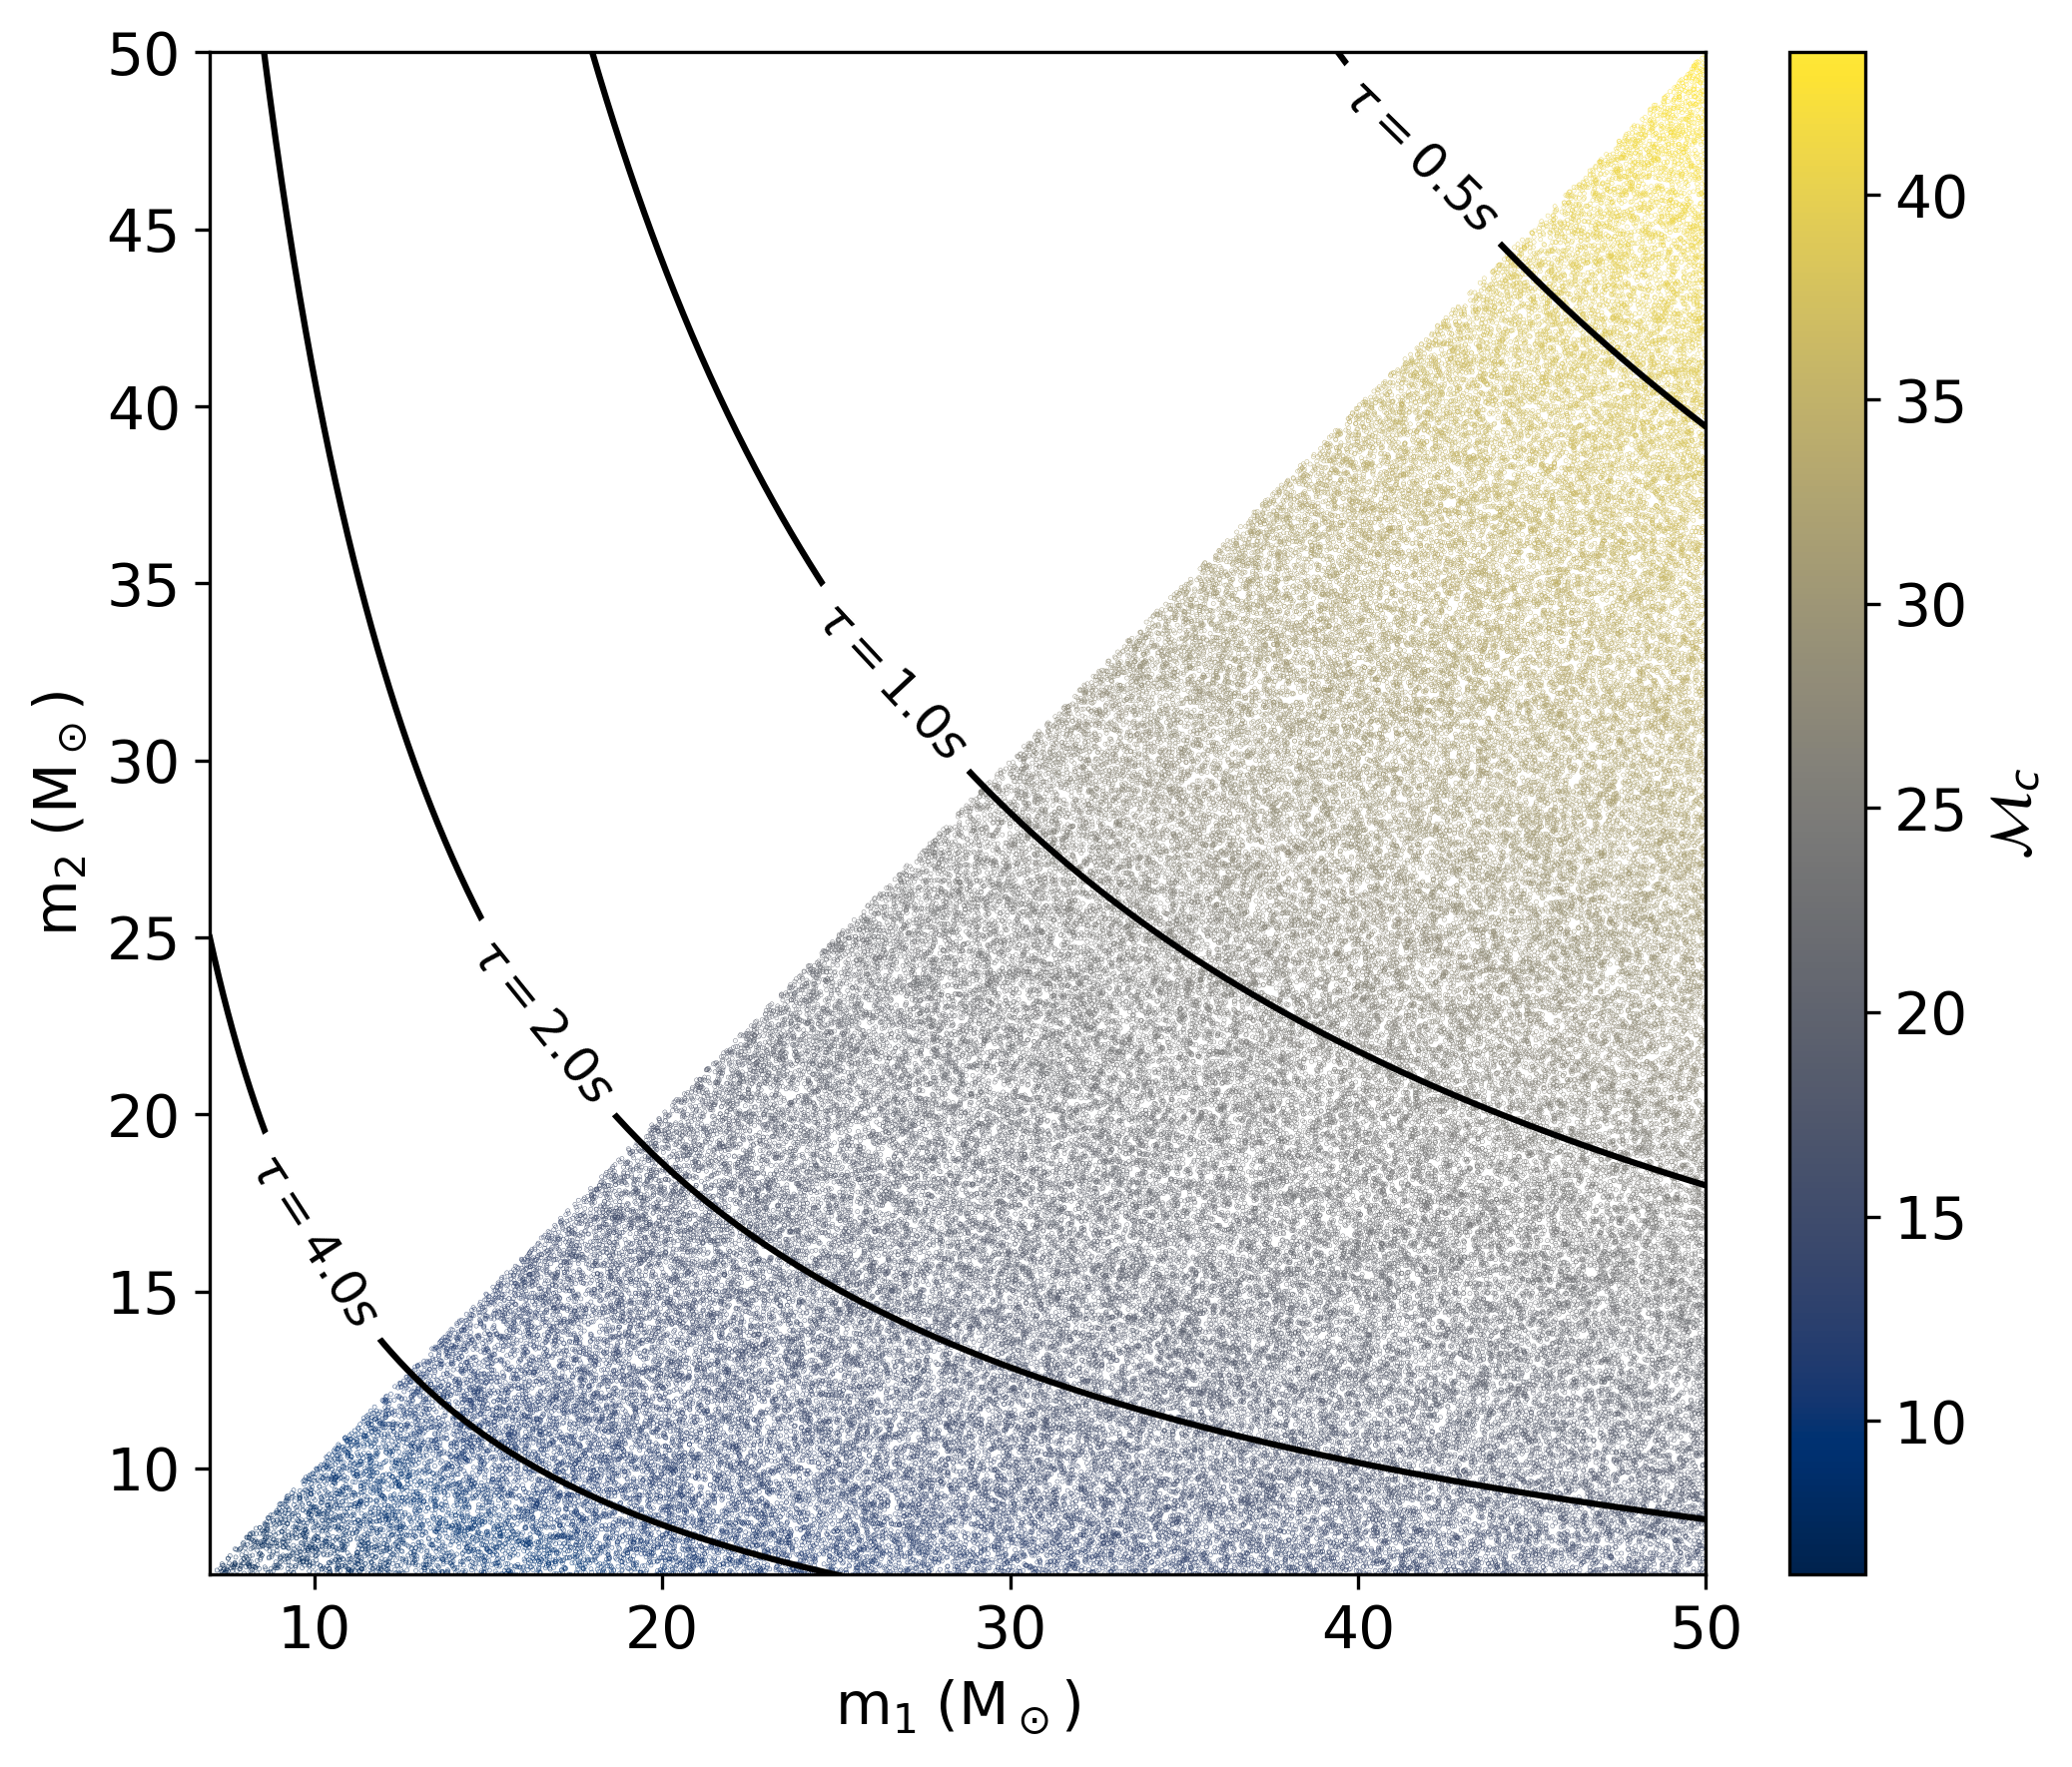

In [16]:
plt.figure(figsize=(7.0, 6.0), dpi=300)
mchirp = (_m1*_m2 / (_m1+_m2)**2.)**(3./5) * (_m1 + _m2)
# cmap_custom = LinearSegmentedColormap.from_list('', ['white', *plt.cm.cividis(np.arange(255))])

plt.scatter(_m1, _m2, s=0.01, c=mchirp, cmap='cividis')
#plt.hist2d(_m1, _m2, cmap='cividis', bins=256)

# Get mchirp from given tau
tau = [0.5, 1.0, 2.0, 4.0]
print('tau = {}'.format(tau))
lf = 20.0 # Signal low frequency cutoff
G = 6.67e-11
c = 3.0e8
mchirp_from_tau = lambda tau: (((5. * (8.*np.pi*lf)**(-8./3.))/tau)**(3./5.))/(1.989e30*G/c**3.)
mchirp_line = [mchirp_from_tau(_tau) for _tau in tau]

# mchirp curve on m1, m2 plot
print('mchirp line at = {}'.format(mchirp_line))
for _mc, _tau in zip(mchirp_line, tau):
    m1_line = np.linspace(ml, mu, 1000)
    m2_line = [_mass2_from_mchirp_mass1(mchirp=_mc, mass1=m1i) for m1i in m1_line]
    plt.plot(m1_line, m2_line, c='k', label=r'$\tau={}s$'.format(_tau))

labelLines(plt.gca().get_lines(), xvals=(41.8, 26.6, 16.55, 10), zorder=2.5, fontsize=12)

# We change the 
#  of minor ticks label 
fontsize = 14
plt.tick_params(axis='both', which='major', labelsize=fontsize)

plt.xlim(ml, mu)
plt.ylim(ml, mu)
plt.xlabel(r'$\mathregular{m_1} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
plt.ylabel(r'$\mathregular{m_2} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
cbar = plt.colorbar(fraction=.05, pad=0.05)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'$\mathcal{M}_c$', size=fontsize)
plt.tight_layout()
plt.savefig('./testing_dataset_priors.png')
#plt.close()

### Experimenting with uTau and uMc

#### Uniform in Signal Duration

In [17]:
def get_tau_priors(ml, mu, lf):
    # m2 will always be slightly lower than m1, but (m, m) will give limit
    # that the mchirp will never reach but tends to as num_samples tends to inf.
    # Range for mchirp can be written as --> (min_mchirp, max_mchirp)
    min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
    max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
    # Tau priors
    G = 6.67e-11
    c = 3.0e8
    tau = lambda mc: 5. * (8.*np.pi*lf)**(-8./3.) * (mc*1.989e30*G/c**3.)**(-5./3.)
    tau_lower = tau(max_mchirp)
    tau_upper = tau(min_mchirp)
    return (tau_lower, tau_upper)

In [18]:
def mchirp_from_uniform_signal_duration(tau_lower, tau_upper, num_samples, signal_low_freq_cutoff):
    # Calculate chirp mass from uniform signal duration
    lf = signal_low_freq_cutoff
    G = 6.67e-11
    c = 3.0e8
    uniform_signal_duration = np.random.uniform(tau_lower, tau_upper, num_samples)
    chirp_mass_from_uniform_tau = ((uniform_signal_duration/5.) * (8.*np.pi*lf)**(8./3.))**(-3./5.) * (c**3./(G*1.989e30))
    return chirp_mass_from_uniform_tau

In [19]:
_mass1, _mass2 = get_uniform_masses(7.0, 50.0, 50_000_000)
# Masses used for mass ratio need not be used later as mass1 and mass2
# We calculate them again after getting chirp mass
q = q_from_uniform_mass1_mass2(_mass1, _mass2)

In [20]:
tau_lower, tau_upper = get_tau_priors(7.0, 50.0, 20.0)
mchirp = mchirp_from_uniform_signal_duration(tau_lower, tau_upper, 50_000_000, 20.0)
mass1, mass2 = mass1_mass2_from_mchirp_q(mchirp, q)

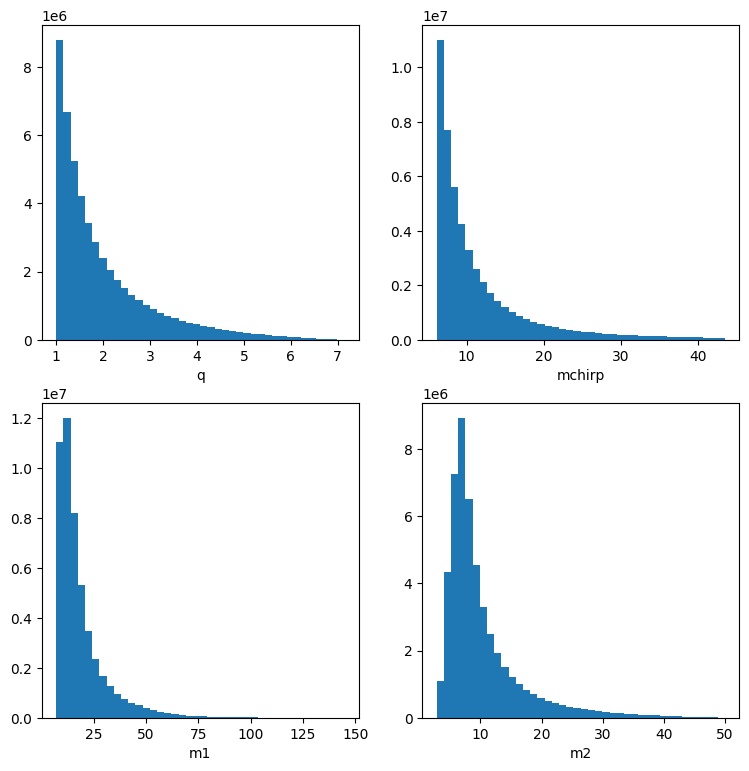

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax[0][0].hist(q, bins=40)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp, bins=40)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(mass1, bins=40)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(mass2, bins=40)
ax[1][1].set_xlabel('m2')
plt.show()

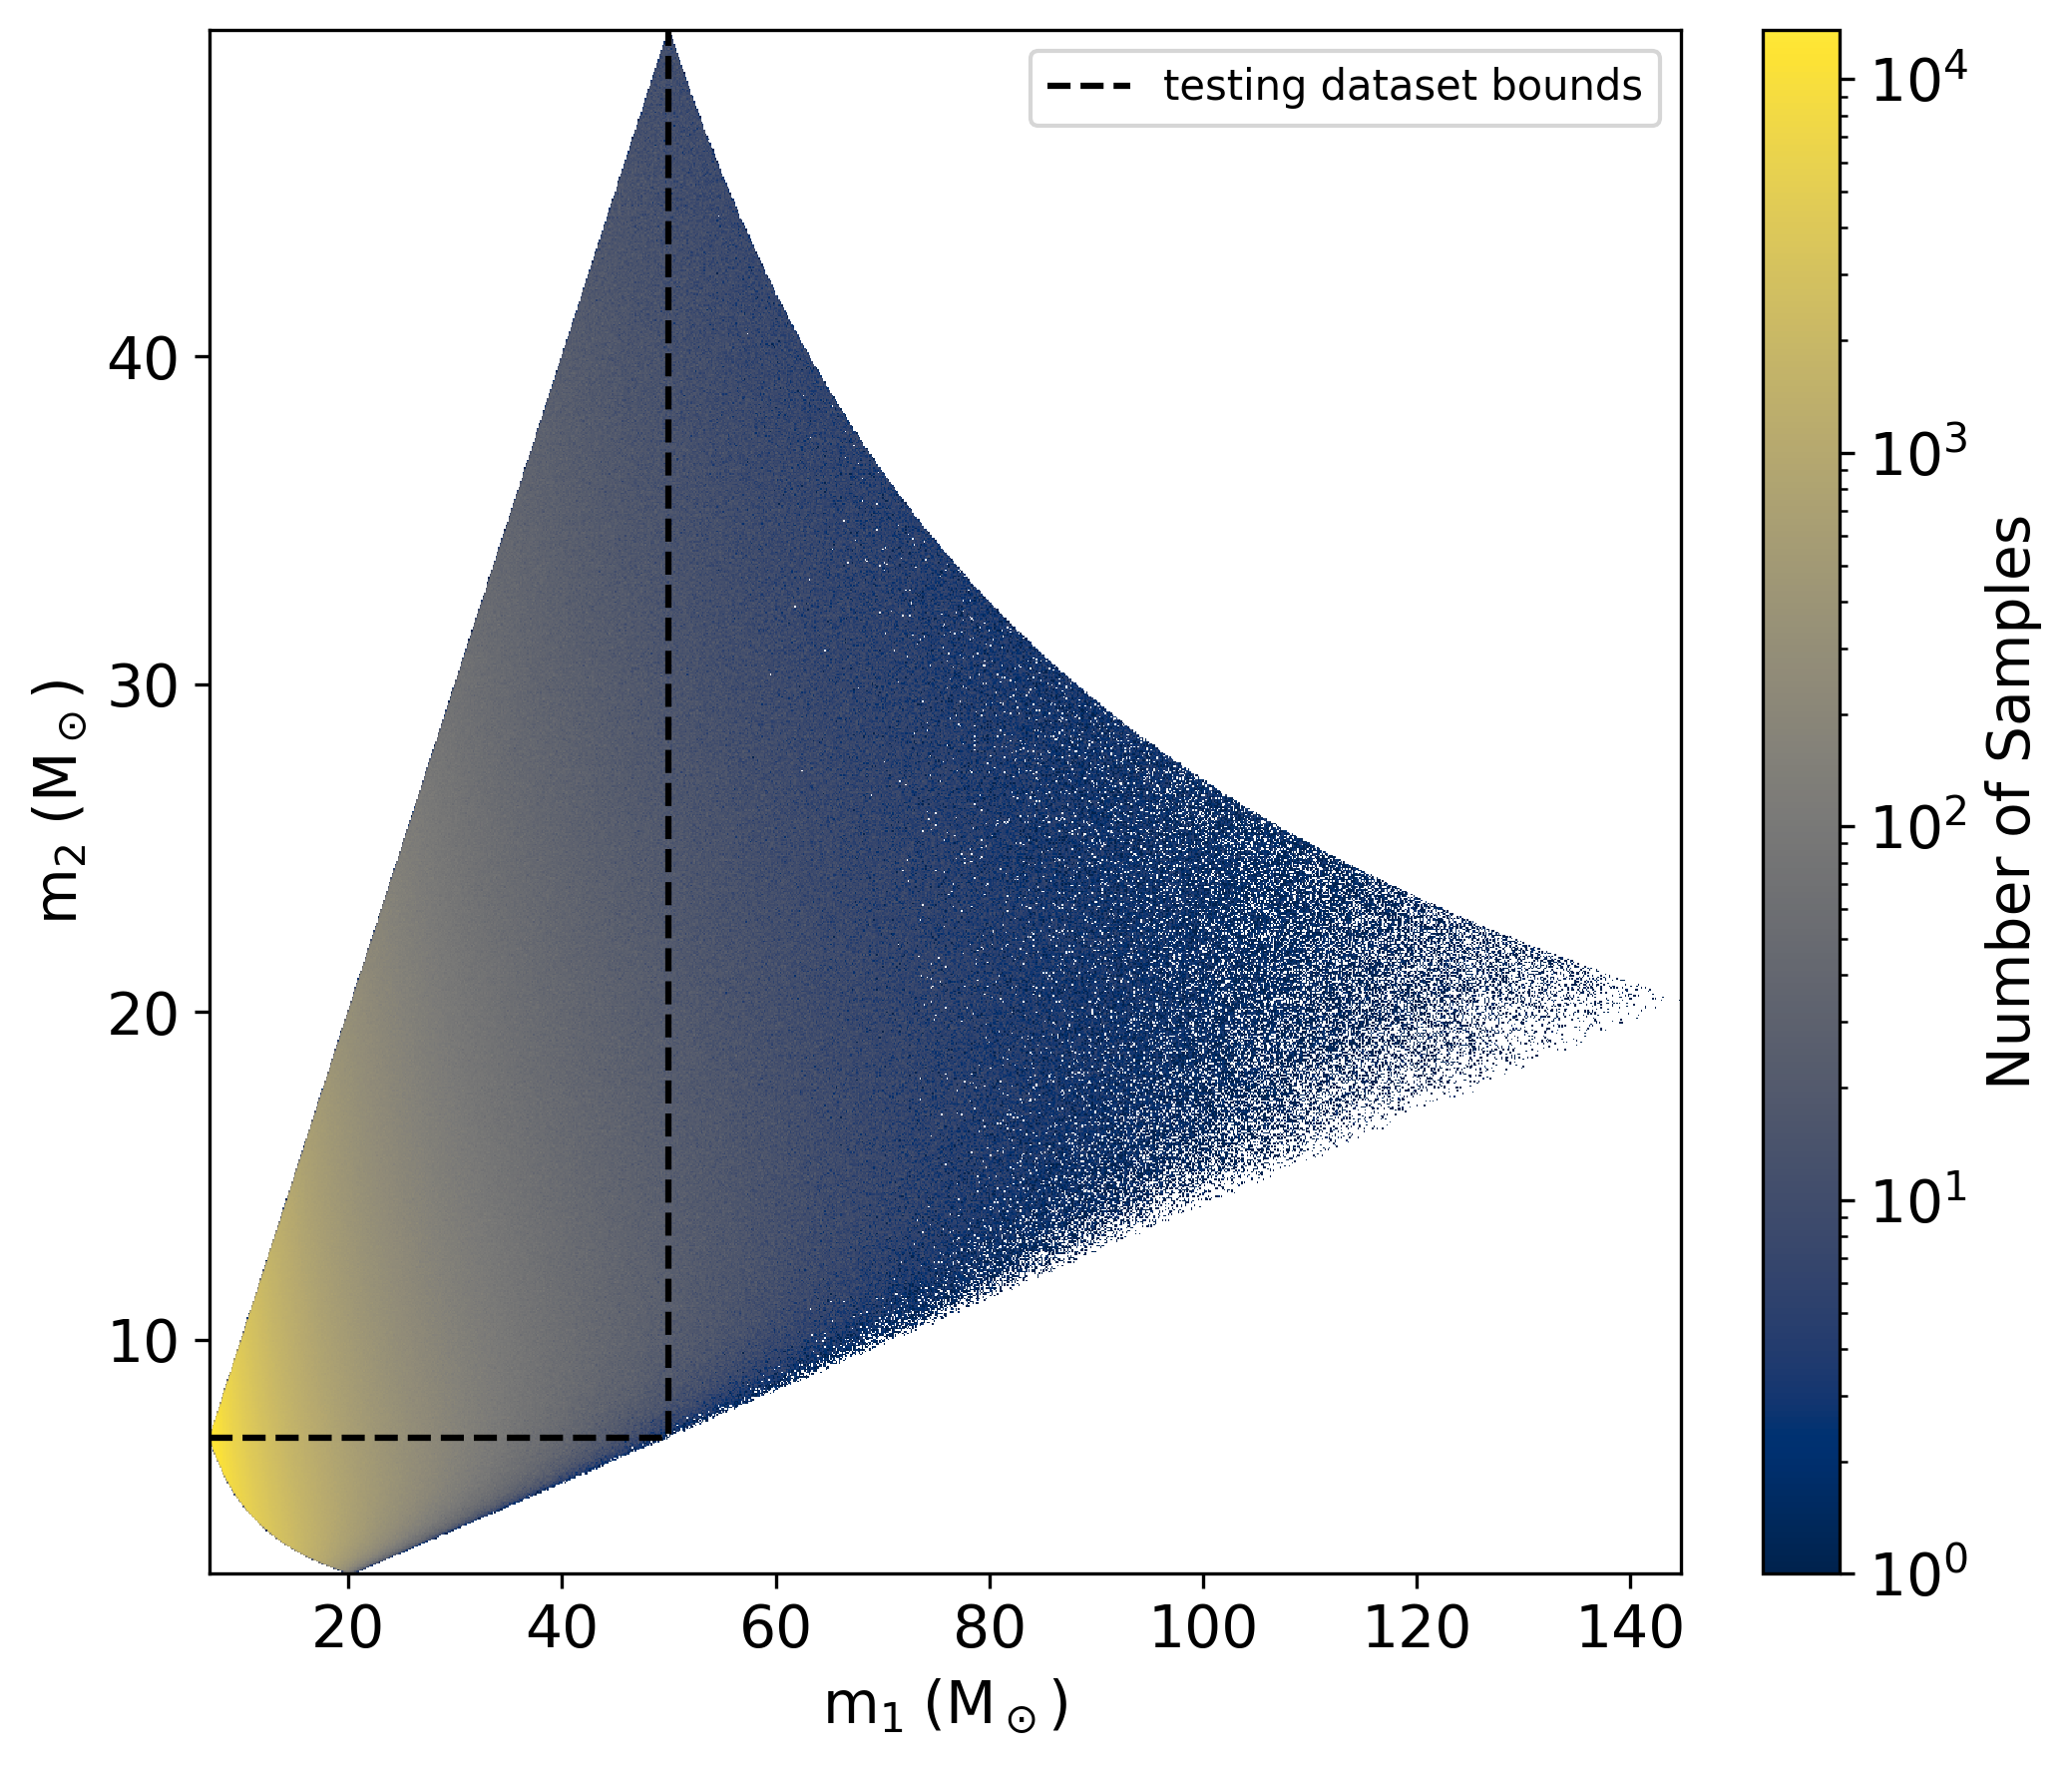

In [22]:
import matplotlib as mpl
plt.figure(figsize=(7.0, 6.0), dpi=300)
plt.hist2d(mass1, mass2, bins=1024, norm=mpl.colors.LogNorm(), cmap=mpl.cm.cividis)
plt.plot([7.0, 50.0, 50.0], [7.0, 7.0, 50.0], c='k', linestyle='dashed', linewidth=1.5, label='testing dataset bounds')

fontsize = 14
plt.tick_params(axis='both', which='major', labelsize=fontsize)

plt.xlabel(r'$\mathregular{m_1} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
plt.ylabel(r'$\mathregular{m_2} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
cbar = plt.colorbar(fraction=.05, pad=0.05)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('Number of Samples', size=fontsize)
plt.legend()
plt.tight_layout()
plt.savefig('./training_dataset_priors.png')

#### Uniform chirp mass

In [30]:
mc_distribution = distributions.Uniform(mc=(minmc,maxmc))
# Mass ratio
minq = 1.0
maxq = 50.0/7.0
q_distribution = distributions.QfromUniformMass1Mass2(q=(minq, maxq))

# Take 100000 random variable samples from this chirp mass and mass ratio
# distribution.
n_size = 100_000
mc_umc = mc_distribution.rvs(size=n_size)
q_umc = q_distribution.rvs(size=n_size)

# Convert chirp mass and mass ratio to mass1 and mass2
mass1_umc = conversions.mass1_from_mchirp_q(mc_samples['mc'],q_samples['q'])
mass2_umc = conversions.mass2_from_mchirp_q(mc_samples['mc'],q_samples['q'])

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
ax[0][0].hist(q_umc['q'], bins=40)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mc_umc['mc'], bins=40)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(mass1_umc, bins=40)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(mass2_umc, bins=40)
ax[1][1].set_xlabel('m2')
plt.show()

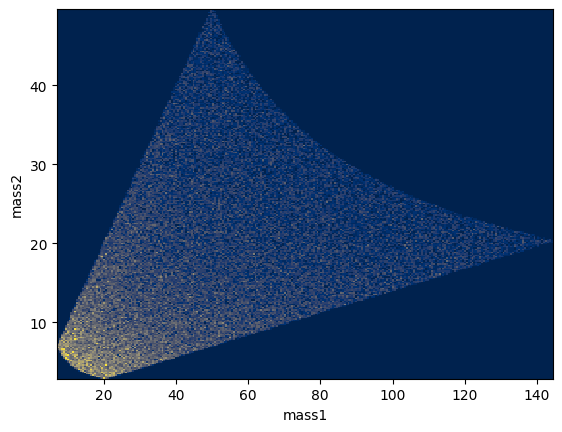

In [45]:
plt.figure()
plt.hist2d(mass1_umc, mass2_umc, bins=256, cmap='cividis')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.show()

#### Comparing uMc, uTau, default

In [64]:
plt.figure()
plt.scatter(mass1_umc, mass2_umc, s=4.0, c='blue', label='uMc', alpha=1.0)
plt.scatter(mass1, mass2, s=4.0, c='red', label='uTau', alpha=1.0)
plt.plot([7.0, 50.0, 50.0], [7.0, 7.0, 50.0], c='k', linestyle='dashed', linewidth=1.5, label='required bounds')
mchirp_worst = 25.0
m1_worst = np.linspace(7.0, 150.0, 10_000)
m2_worst = [_mass2_from_mchirp_mass1(mchirp_worst, m1w) for m1w in m1_worst]
plt.plot(m1_worst, m2_worst, c='k', label='worst performance (160324)')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.xlim(7.0, max(mass1_umc))
plt.ylim(min(mass2_umc), max(mass2_umc))
plt.legend()
plt.show()

In [65]:
plt.figure()
plt.scatter(mass1, mass2, s=4.0, c=q, label='uTau', cmap='cividis')
mchirp_worst = 25.0
m1_worst = np.linspace(7.0, 150.0, 10_000)
m2_worst = [_mass2_from_mchirp_mass1(mchirp_worst, m1w) for m1w in m1_worst]
plt.plot(m1_worst, m2_worst, c='k', label='worst performance (160324)')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.xlim(7.0, max(mass1_umc))
plt.ylim(min(mass2_umc), max(mass2_umc))
plt.legend()
plt.show()

We might be confusing the network with too many high mass ratio waveforms.

In [72]:
mass1, mass2 = get_uniform_masses(7., 50., 100_000)
q = mass1/mass2
mchirp = (mass1*mass2/ (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)

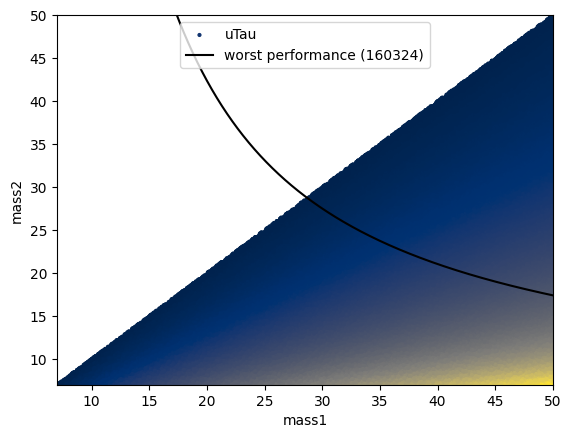

In [74]:
plt.figure()
plt.scatter(mass1, mass2, s=4.0, c=q, label='uTau', cmap='cividis')
mchirp_worst = 25.0
m1_worst = np.linspace(7.0, 150.0, 10_000)
m2_worst = [_mass2_from_mchirp_mass1(mchirp_worst, m1w) for m1w in m1_worst]
plt.plot(m1_worst, m2_worst, c='k', label='worst performance (160324)')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.xlim(7.0, 50.0)
plt.ylim(7.0, 50.0)
plt.legend()
plt.show()

I can't find a solid reason why this mchirp curve is troublesome. Since there are no apparent biases, I will try looking at other reasons.

### Testing bug with tc and this somehow being related to SNR

In [1]:
from scipy.stats import halfnorm

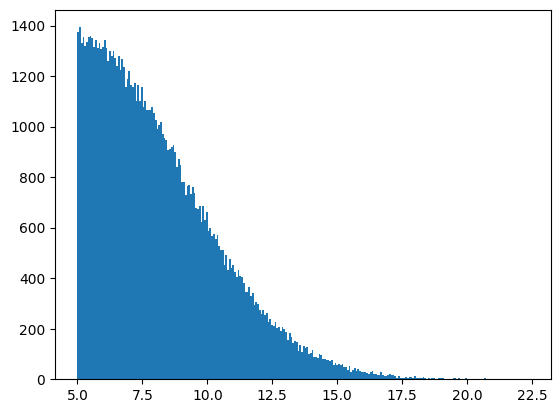

In [9]:
target_snrs = [halfnorm.rvs() * 4.0 + 5.0 for _ in range(100_000)]
plt.hist(target_snrs, bins=256)
plt.show()

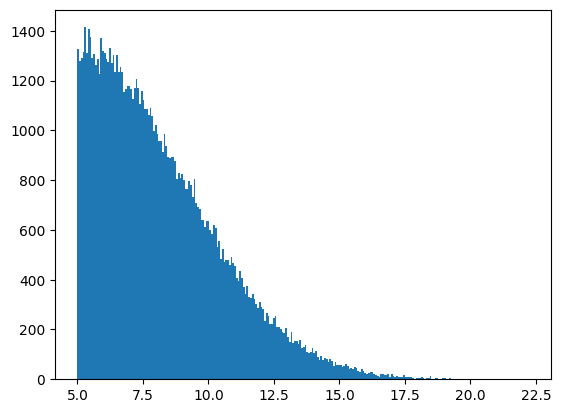

In [8]:
target_snrs = []
for seed in range(100_000):
    np.random.seed(seed)
    target_snrs.append(halfnorm.rvs() * 4.0 + 5.0)

plt.hist(target_snrs, bins=256)
plt.show()